# Using the XBBG module to extract and analyze historic bond data for corporate hybrids

# written by: Darren Lefcoe
Jul 2020

contact:
* gitHub: @dlefcoe
* twitter: @dlefcoe
* email: darren@redhedge.uk


## Redhedge Asset Management

Darren Lefcoe uses open source to create and write code for RedHedge.

Running an open source project, like any human endeavor, involves uncertainty and trade-offs.

Please refer to the open source licences:
https://opensource.guide/notices/


# First we do the imports

In [254]:
import os
import sys

import time
import datetime
import collections

import blpapi
from xbbg import blp


import openpyxl
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
import numpy as np

import pandas_profiling #something new

import imgkit # for styling
import dateutil # possibly not needed


In [59]:
#pd.__version__

In [58]:
#pd.show_versions()

In [3]:
# given limit for bloomberg data
bloombergLimit = 500_000



In [4]:
# get the file path of this file
dir_path = os.path.abspath('')



In [362]:
# define a list of bond fields
fieldList = ['ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
            'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
            'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody',
             'rtg_sp','yas_mod_dur','workout_dt_years_tdy','reset_idx','basic_spread',
            'workout_dt_years_tdy']




In [363]:
# define bond list

# get items from sheet (in the same folder)
fileToGet = 'hybridSecurityList.xlsx'

# join file and correct folder
fileToGet = os.path.join(dir_path, fileToGet)
secListXlsx = pd.ExcelFile(fileToGet)

# the names of the available sheets
print('getting security list from:', secListXlsx.sheet_names)



getting security list from: ['worksheets', 'tickers']


In [7]:

# put bond list into a pandas dataframe
df = pd.DataFrame(secListXlsx.parse('tickers'))




# Lets see the bond list data

In [8]:
df


QJ937853 Corp  XS1323897485      SOLBBB 5.118 PERP nc-21
0    EJ917655 Corp  XS0992293901      SOLBBB 5.425 PERP nc-23
1    AV915324 Corp  BE6309987400      SOLBBB 4 1/4 PERP nc-23
2    QJ937566 Corp  XS1323897725      SOLBBB 5.869 PERP nc-24
3    EK834863 Corp  DE000A14J611  BAYNGR 2 3/8 04/02/75 nc-22
4    EK352403 Corp  DE000A11QR73  BAYNGR 3 3/4 07/01/74 nc-24
..             ...           ...                          ...
180  EK523297 Corp  DE000A1ZN206           WIEAV 5 PERP nc-21
181  AM679347 Corp  XS1582433428      TRAFIG 6 7/8 PERP nc-21
182  AZ920495 Corp  XS2033327854      TRAFIG 7 1/2 PERP nc-24
183  AO262498 Corp  XS1642682410          SOFTBK 6 PERP nc-23
184  AO262515 Corp  XS1642686676      SOFTBK 6 7/8 PERP nc-27

[185 rows x 3 columns]

# A function to get the bond data

In [9]:
def getListDataFromBbg(securtiyList, fieldList):
    ''' 
    gets data from bloomberg using a while loop until completion

        inputs:
            securtiyList - list of tickers to obtain
            fieldList - the fields requested for each ticker

        output:
            resultsOfDataReq - resulting pandas array of the data that was requested

    '''
    # get the data (bdp returns a dataframe)
    resultsOfDataReq = blp.bdp(tickers=securtiyList, flds=fieldList)

    
    #pre-loop initialization
    keepLooping = True
    loopingCounter = 0
    while keepLooping:
        
        # check which items are missing
        listError = list(set(securtiyList)-set(resultsOfDataReq.index.values))
        
        if len(listError) == 0:
            # data collection process finished
            keepLooping = False
            break
        else:
            print(len(listError), 'of', len(securtiyList), 'remaining', ': loop', loopingCounter)
            loopingCounter += 1
            if loopingCounter > 10:
                # more than 10 tries at data collection
                keepLooping = False
                break

        # get and append more data
        try:
            nextChunk = blp.bdp(tickers=listError, flds=fieldList)
            resultsOfDataReq = resultsOfDataReq.append(nextChunk)
        except:
            print('no data to add')

        # remove duplicates
        resultsOfDataReq = resultsOfDataReq.drop_duplicates()

    return resultsOfDataReq

#%time
    

# There are 2 ways of getting history

- from bloomberg
- from a file


## Get historic bond data from BBG
### This works for equity, but not bond data.  Checking with BBG & stack.

https://stackoverflow.com/questions/63230341/from-xbbg-import-blp-works-for-equity-but-does-not-work-for-bonds




In [10]:
def getHistoryExample():
    '''
    fucction to get historic isin history from BBG
    '''

    # return equity data
    eqData = blp.bdh(
        tickers='SPX Index', flds=['high', 'low', 'last_price'],
        start_date='2018-10-10', end_date='2018-10-20',
        )

    print(eqData)

    print('')
    print('getting bond data...')

    # return bond data
    bondData = blp.bdh(
        tickers='XS1152338072 Corp', flds=['px_bid', 'px_ask', 'blp_i_sprd_mid'],
        start_date='2019-10-10', end_date='2019-10-20',
        )

    print(bondData)
    # print(bondData.columns)

    return 


getHistoryExample()


           SPX Index                    
                high      low last_price
2018-10-10   2874.02  2784.86    2785.68
2018-10-11   2795.14  2710.51    2728.37
2018-10-12   2775.77  2729.44    2767.13
2018-10-15   2775.99  2749.03    2750.79
2018-10-16   2813.46  2766.91    2809.92
2018-10-17   2816.94  2781.81    2809.21
2018-10-18   2806.04  2755.18    2768.78
2018-10-19   2797.77  2760.27    2767.78

getting bond data...
           XS1152338072 Corp                        
                      px_bid   px_ask blp_i_sprd_mid
2019-10-10           103.495  103.948         79.928
2019-10-11           103.522  103.963         77.704
2019-10-14           103.537  103.958         76.124
2019-10-15           103.540  103.963         74.418
2019-10-16           103.530  103.966         72.720
2019-10-17           103.568  103.996         69.392
2019-10-18           103.534  103.984         69.708


In [11]:
def getHistoryFromISIN(isin: str):
    '''
    function that takes an isin as a string and returns a DataFrame for the ISIN 
    '''

    # get dates to use (in the correct format)
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)

    # fields that we want to get
    fieldList = ['px_bid', 'px_ask', 'blp_i_sprd_mid']
    #fieldList = ['blp_i_sprd_mid']

    # request from bbg returning a MultiIndex DataFrame object    
    bondDataHist = blp.bdh(
        tickers= isin+' Corp', flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )


    return bondDataHist
bondDataHist = getHistoryFromISIN('XS1152338072')
bondDataHist





lets go between today and 2 years ago
today: 2020-08-17
2y ago: 2018-08-18


XS1152338072 Corp                        
                      px_bid   px_ask blp_i_sprd_mid
2018-08-20           103.521  104.059        129.557
2018-08-21           103.674  104.160        124.221
2018-08-22           103.714  104.268        120.866
2018-08-23           103.737  104.301        119.480
2018-08-24           103.729  104.274        120.150
...                      ...      ...            ...
2020-08-11           101.263  102.043        100.188
2020-08-12           101.329  102.020         97.113
2020-08-13           101.324  102.013         92.875
2020-08-14           101.296  101.917        100.528
2020-08-17           101.289  101.900            NaN

[509 rows x 3 columns]

#### get the average spread

In [12]:

print('the mean is', bondDataHist.mean())
print('the standard deviation is', bondDataHist.std())
#x['blp_i_sprd_mid'].mean()

the mean is XS1152338072 Corp  px_bid            102.518132
                   px_ask            103.090352
                   blp_i_sprd_mid    131.329583
dtype: float64
the standard deviation is XS1152338072 Corp  px_bid             1.601504
                   px_ask             1.485587
                   blp_i_sprd_mid    90.658859
dtype: float64


### plot a time series for the spreads






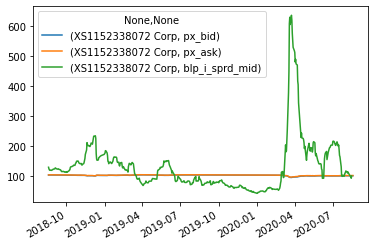

In [45]:
#bondDataHist.plot(x='nxt_call_dt',y='blp_i_sprd_mid')
bondDataHist.plot()

<class 'pandas.core.frame.DataFrame'>
MultiIndex([('XS1152338072 Corp',         'px_bid'),
            ('XS1152338072 Corp',         'px_ask'),
            ('XS1152338072 Corp', 'blp_i_sprd_mid')],
           )


131.32958267716535

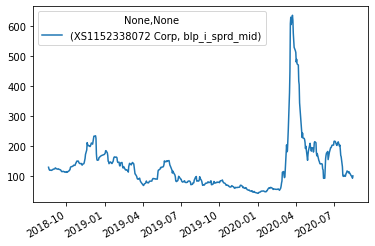

In [14]:
# plot just spread
print(type(bondDataHist))
#bondDataHist.plot(x=, y='blp_i_sprd_mid')

# works
#plt.plot(bondDataHist.index, bondDataHist.values)
# bondDataHist.plot(y='blp_i_sprd_mid', use_index=True)
bondDataHist.plot(y=('XS1152338072 Corp', 'blp_i_sprd_mid'))

# note this is a multi index (whatever that means)
print(bondDataHist.columns)

x = bondDataHist[('XS1152338072 Corp', 'blp_i_sprd_mid')]
x.mean()





## get data for multiple bonds




In [344]:
all_VW_bonds = ['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 
                'XS2187689034', 'XS1048428442', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366']

listOfBonds = all_VW_bonds




In [345]:
def getHistoryFromISIN_list(isin_list: list):
    ''' function to get historic data from a list of isins  '''

    # list of isins
    isin_list = [i + ' Corp' for i in isin_list]
    print('here is the list: ', isin_list)

    # fields
    fieldList = 'blp_i_sprd_mid'

    # start and end dates to use
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)



    # request from bbg returning a MultiIndex DataFrame object    
    bondDataHist = blp.bdh(
        tickers= isin_list, flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )
    

    return bondDataHist

vwHist = getHistoryFromISIN_list(listOfBonds)
vwHist


here is the list:  ['XS1048428012 Corp', 'XS1206540806 Corp', 'XS1629658755 Corp', 'XS0968913342 Corp', 'XS1799938995 Corp', 'XS2187689034 Corp', 'XS1048428442 Corp', 'XS1629774230 Corp', 'XS1799939027 Corp', 'XS2187689380 Corp', 'XS1206541366 Corp']
lets go between today and 2 years ago
today: 2020-08-20
2y ago: 2018-08-21


XS0968913342 Corp XS1048428012 Corp XS1048428442 Corp  \
              blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
2018-08-21            273.07            195.72            323.19   
2018-08-22            269.87            193.12            320.89   
2018-08-23            272.17            194.73            324.48   
2018-08-24            277.51            196.19            327.55   
2018-08-27            275.89            197.07            326.47   
...                      ...               ...               ...   
2020-08-13            293.57            128.44            341.81   
2020-08-14            299.37            156.00            347.94   
2020-08-17            308.27            188.87            358.89   
2020-08-18            317.24            201.75            361.49   
2020-08-19            324.09            211.97            365.60   

           XS1206540806 Corp XS1206541366 Corp XS1629658755 Corp  \
              blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
2018-08-21            255.90            331.61            268.76   
2018-08-22            253.04            330.52            265.78   
2018-08-23            256.24            333.45            269.50   
2018-08-24            255.79            334.22            270.68   
2018-08-27            254.71            331.22            267.93   
...                      ...               ...               ...   
2020-08-13            230.57            375.48            263.22   
2020-08-14            240.51            381.04            268.28   
2020-08-17            265.12            389.90            289.45   
2020-08-18            271.03            393.06            292.06   
2020-08-19            276.58            395.56            297.58   

           XS1629774230 Corp XS1799938995 Corp XS1799939027 Corp  \
              blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
2018-08-21            362.12            321.95            364.69   
2018-08-22            360.87            320.07            364.44   
2018-08-23            364.42            324.42            370.31   
2018-08-24            366.57            325.45            370.61   
2018-08-27            365.63            324.83            370.50   
...                      ...               ...               ...   
2020-08-13            361.49            320.85            379.15   
2020-08-14            367.94            327.61            385.41   
2020-08-17            379.76            346.00            397.21   
2020-08-18            382.81            353.57            402.58   
2020-08-19            388.15            356.32            404.01   

           XS2187689034 Corp XS2187689380 Corp  
              blp_i_sprd_mid    blp_i_sprd_mid  
2018-08-21               nan               nan  
2018-08-22               nan               nan  
2018-08-23               nan               nan  
2018-08-24               nan               nan  
2018-08-27               nan               nan  
...                      ...               ...  
2020-08-13            339.66            379.97  
2020-08-14            346.36            387.83  
2020-08-17            363.39            398.53  
2020-08-18            365.16            399.64  
2020-08-19            368.01            400.13  

[510 rows x 11 columns]

In [113]:
vwHist.describe()


XS0968913342 Corp XS1048428012 Corp XS1206540806 Corp XS1206541366 Corp  \
         blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
count        510.000000        510.000000        510.000000        510.000000   
mean         290.818061        223.002016        276.817325        356.287461   
std           96.532408        149.158677        110.381043         63.546637   
min          144.402000         64.053000        128.812000        258.862000   
25%          227.055000        123.730750        197.618500        320.750750   
50%          271.292500        189.007000        257.610000        347.004500   
75%          339.508000        262.125000        329.755500        382.987000   
max          754.996000        860.316000        870.351000        730.035000   

      XS1629658755 Corp XS1629774230 Corp XS1799938995 Corp XS1799939027 Corp  \
         blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
count        510.000000        510.000000        510.000000        510.000000   
mean         294.399239        382.252575        337.759496        390.452339   
std          104.427025         80.692945         93.464081         71.561285   
min          143.045000        254.274000        185.697000        268.958000   
25%          219.876000        331.376500        271.288000        345.427750   
50%          277.412000        379.161000        336.162500        388.309000   
75%          351.104000        423.493500        392.855500        431.125500   
max          793.130000        744.702000        768.710000        716.388000   

      XS2187689034 Corp XS2187689380 Corp  
         blp_i_sprd_mid    blp_i_sprd_mid  
count         48.000000         48.000000  
mean         388.423854        414.121292  
std           22.200057         16.654507  
min          339.662000        379.151000  
25%          371.151750        399.755750  
50%          396.990000        420.663000  
75%          405.074500        425.232250  
max          419.973000        442.270000

In [120]:
# prep & deploy the pandas profile module

# create new df and then drop multiindex from new df (required for pandas_profiling)
vw_singleIndex = vwHist.copy()
vw_singleIndex.columns = vw_singleIndex.columns.droplevel(level=1)
# vw_singleIndex

# pandas profiling
pandas_profiling.ProfileReport(vw_singleIndex)


In [18]:
#extracting data from the DataFrame
#print(vwHist.describe().iloc[0]) # works
#print(vwHist.describe().loc['max']) # works

# get the max of one bond
print('the max is ', vwHist.describe().loc[['max'],[('XS0968913342 Corp',  'blp_i_sprd_mid')]].values)


the max is  [[754.996]]


In [19]:
# save to csv

# time stamp & path etc.
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_isprd_HistoryStats ' + ts + '.csv'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'csvData', fileToSave)

# export to csv
vwHist.describe().to_csv(fileToSave)
print('file saved here: ', fileToSave)


file saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\csvData\bond_isprd_HistoryStats 2020-08-17 11_19_44.csv


the columns
MultiIndex([('XS0968913342 Corp', 'blp_i_sprd_mid'),
            ('XS1048428012 Corp', 'blp_i_sprd_mid'),
            ('XS1048428442 Corp', 'blp_i_sprd_mid'),
            ('XS1206540806 Corp', 'blp_i_sprd_mid'),
            ('XS1206541366 Corp', 'blp_i_sprd_mid'),
            ('XS1629658755 Corp', 'blp_i_sprd_mid'),
            ('XS1629774230 Corp', 'blp_i_sprd_mid'),
            ('XS1799938995 Corp', 'blp_i_sprd_mid'),
            ('XS1799939027 Corp', 'blp_i_sprd_mid'),
            ('XS2187689034 Corp', 'blp_i_sprd_mid'),
            ('XS2187689380 Corp', 'blp_i_sprd_mid')],
           )
the means:
XS0968913342 Corp  blp_i_sprd_mid    290.731687
XS1048428012 Corp  blp_i_sprd_mid    223.111039
XS1048428442 Corp  blp_i_sprd_mid    351.794063
XS1206540806 Corp  blp_i_sprd_mid    276.851744
XS1206541366 Corp  blp_i_sprd_mid    356.148911
XS1629658755 Corp  blp_i_sprd_mid    294.413585
XS1629774230 Corp  blp_i_sprd_mid    382.256374
XS1799938995 Corp  blp_i_sprd_mid    337.712

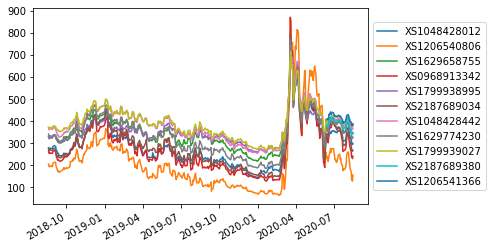

In [20]:
## do some basic stats

print('the columns')
# vwHist.columns=all_VW_bonds
print(vwHist.columns)
print('the means:')
print(vwHist.mean())
print('the st devs:')
print(vwHist.std())

vwHist.plot().legend(all_VW_bonds, loc='center left', bbox_to_anchor=(1.0, 0.5))



# We need the current data (for the names instead of isins)

In [21]:
def getVWbondData(isin_list: list):
    ''' function to get VW bond data '''

    # isins
    isin_list = [i + " Corp" for i in isin_list]

    # fields
    fieldList = ['id_isin', 'security_name', 'name', 'ticker' ,'cpn', 'nxt_call_dt', 'yas_ispread','rtg_moody', 'rtg_sp']

    vwDF = getListDataFromBbg(isin_list,  fieldList)


    return vwDF


vw = getVWbondData(all_VW_bonds)
print(all_VW_bonds)
vw

['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 'XS2187689034', 'XS1048428442', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366']


id_isin  security_name                    name ticker  \
XS0968913342 Corp  XS0968913342  VW 5 1/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1048428012 Corp  XS1048428012  VW 3 3/4 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1048428442 Corp  XS1048428442  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206540806 Corp  XS1206540806  VW 2 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206541366 Corp  XS1206541366  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629658755 Corp  XS1629658755    VW 2.7 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629774230 Corp  XS1629774230  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799938995 Corp  XS1799938995  VW 3 3/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799939027 Corp  XS1799939027  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689034 Corp  XS2187689034  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689380 Corp  XS2187689380  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   

                     cpn nxt_call_dt yas_ispread rtg_moody rtg_sp  
XS0968913342 Corp  5.125  2023-09-04     303.362      Baa2   BBB-  
XS1048428012 Corp   3.75  2021-03-24     182.971      Baa2   BBB-  
XS1048428442 Corp  4.625  2026-03-24     354.016      Baa2   BBB-  
XS1206540806 Corp    2.5  2022-03-20     252.647      Baa2   BBB-  
XS1206541366 Corp    3.5  2030-03-20     386.051      Baa2   BBB-  
XS1629658755 Corp    2.7  2022-12-14     280.394      Baa2   BBB-  
XS1629774230 Corp  3.875  2027-06-14     373.739      Baa2   BBB-  
XS1799938995 Corp  3.375  2024-06-27     336.749      Baa2   BBB-  
XS1799939027 Corp  4.625  2028-06-27     392.593      Baa2   BBB-  
XS2187689034 Corp    3.5  2025-06-17     353.124      Baa2   BBB-  
XS2187689380 Corp  3.875  2029-06-17     394.485      Baa2   BBB-

In [22]:
# add a unique name
vw['uniqueName'] = vw['ticker'] +  " " + vw['cpn'].astype(str) + " -c " + vw['nxt_call_dt'].astype(str).str[2:4]
vw

id_isin  security_name                    name ticker  \
XS0968913342 Corp  XS0968913342  VW 5 1/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1048428012 Corp  XS1048428012  VW 3 3/4 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1048428442 Corp  XS1048428442  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206540806 Corp  XS1206540806  VW 2 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206541366 Corp  XS1206541366  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629658755 Corp  XS1629658755    VW 2.7 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629774230 Corp  XS1629774230  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799938995 Corp  XS1799938995  VW 3 3/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799939027 Corp  XS1799939027  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689034 Corp  XS2187689034  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689380 Corp  XS2187689380  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   

                     cpn nxt_call_dt yas_ispread rtg_moody rtg_sp  \
XS0968913342 Corp  5.125  2023-09-04     303.362      Baa2   BBB-   
XS1048428012 Corp   3.75  2021-03-24     182.971      Baa2   BBB-   
XS1048428442 Corp  4.625  2026-03-24     354.016      Baa2   BBB-   
XS1206540806 Corp    2.5  2022-03-20     252.647      Baa2   BBB-   
XS1206541366 Corp    3.5  2030-03-20     386.051      Baa2   BBB-   
XS1629658755 Corp    2.7  2022-12-14     280.394      Baa2   BBB-   
XS1629774230 Corp  3.875  2027-06-14     373.739      Baa2   BBB-   
XS1799938995 Corp  3.375  2024-06-27     336.749      Baa2   BBB-   
XS1799939027 Corp  4.625  2028-06-27     392.593      Baa2   BBB-   
XS2187689034 Corp    3.5  2025-06-17     353.124      Baa2   BBB-   
XS2187689380 Corp  3.875  2029-06-17     394.485      Baa2   BBB-   

                       uniqueName  
XS0968913342 Corp  VW 5.125 -c 23  
XS1048428012 Corp   VW 3.75 -c 21  
XS1048428442 Corp  VW 4.625 -c 26  
XS1206540806 Corp    VW 2.5 -c 22  
XS1206541366 Corp    VW 3.5 -c 30  
XS1629658755 Corp    VW 2.7 -c 22  
XS1629774230 Corp  VW 3.875 -c 27  
XS1799938995 Corp  VW 3.375 -c 24  
XS1799939027 Corp  VW 4.625 -c 28  
XS2187689034 Corp    VW 3.5 -c 25  
XS2187689380 Corp  VW 3.875 -c 29

In [346]:
# sort by next call date

print(vw.columns)
print(vw.index)

vwsorted_byDate = vw.sort_values(by='nxt_call_dt')
vwsorted_byDate


Index(['id_isin', 'security_name', 'name', 'ticker', 'cpn', 'nxt_call_dt',
       'yas_ispread', 'rtg_moody', 'rtg_sp', 'uniqueName'],
      dtype='object')
Index(['XS0968913342 Corp', 'XS1048428012 Corp', 'XS1048428442 Corp',
       'XS1206540806 Corp', 'XS1206541366 Corp', 'XS1629658755 Corp',
       'XS1629774230 Corp', 'XS1799938995 Corp', 'XS1799939027 Corp',
       'XS2187689034 Corp', 'XS2187689380 Corp'],
      dtype='object')


id_isin  security_name                    name ticker  \
XS1048428012 Corp  XS1048428012  VW 3 3/4 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206540806 Corp  XS1206540806  VW 2 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629658755 Corp  XS1629658755    VW 2.7 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS0968913342 Corp  XS0968913342  VW 5 1/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799938995 Corp  XS1799938995  VW 3 3/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689034 Corp  XS2187689034  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1048428442 Corp  XS1048428442  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629774230 Corp  XS1629774230  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799939027 Corp  XS1799939027  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689380 Corp  XS2187689380  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206541366 Corp  XS1206541366  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   

                   cpn nxt_call_dt yas_ispread rtg_moody rtg_sp  \
XS1048428012 Corp 3.75  2021-03-24      182.97      Baa2   BBB-   
XS1206540806 Corp 2.50  2022-03-20      252.65      Baa2   BBB-   
XS1629658755 Corp 2.70  2022-12-14      280.39      Baa2   BBB-   
XS0968913342 Corp 5.12  2023-09-04      303.36      Baa2   BBB-   
XS1799938995 Corp 3.38  2024-06-27      336.75      Baa2   BBB-   
XS2187689034 Corp 3.50  2025-06-17      353.12      Baa2   BBB-   
XS1048428442 Corp 4.62  2026-03-24      354.02      Baa2   BBB-   
XS1629774230 Corp 3.88  2027-06-14      373.74      Baa2   BBB-   
XS1799939027 Corp 4.62  2028-06-27      392.59      Baa2   BBB-   
XS2187689380 Corp 3.88  2029-06-17      394.48      Baa2   BBB-   
XS1206541366 Corp 3.50  2030-03-20      386.05      Baa2   BBB-   

                       uniqueName  
XS1048428012 Corp   VW 3.75 -c 21  
XS1206540806 Corp    VW 2.5 -c 22  
XS1629658755 Corp    VW 2.7 -c 22  
XS0968913342 Corp  VW 5.125 -c 23  
XS1799938995 Corp  VW 3.375 -c 24  
XS2187689034 Corp    VW 3.5 -c 25  
XS1048428442 Corp  VW 4.625 -c 26  
XS1629774230 Corp  VW 3.875 -c 27  
XS1799939027 Corp  VW 4.625 -c 28  
XS2187689380 Corp  VW 3.875 -c 29  
XS1206541366 Corp    VW 3.5 -c 30

### Here is the VW yield curve

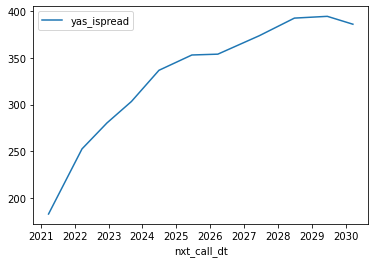

In [24]:
vwsorted_byDate.plot(x='nxt_call_dt', y='yas_ispread')

### merge the historic data to the current data


In [25]:
# merge table

def mergeDataFramesWithHistorySeries_vw(df1, df2):
    ''' 
    function to merge dataframes
        
    inputs: 
        df1: first dataframe
        df2: second dataframe

    outputs:
        dfOut: output DataFrame

    '''
    

    # Cannot merge a Series without a name => df2 needs to have a name  (solved with rename())
    # ValueError: cannot join with no overlapping index names (solved with droplevel())
    
    #dfOut = df1.merge(df2.rename('mean_2y'),left_index=True, right_index=True)
    dfOut = df1.merge(df2,left_index=True, right_index=True)
    # print('\n\noutput dataframe:')
    
    # print(dfOut)

    return dfOut


# run function (MultiLevel series renamed and dropped to single level)
vw_merged = mergeDataFramesWithHistorySeries_vw(vwsorted_byDate, vwHist.iloc[-180:-1].mean().rename('mean_1y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.mean().rename('mean_2y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.std().rename('std_2y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.min().rename('min_2y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.max().rename('max_2y').droplevel(level=1))

# additional stats to add
vwmean = vwHist.ewm(halflife=0.25).mean().tail(1).transpose().reset_index().set_index('level_0')
vwstd =  vwHist.ewm(halflife=0.25).std().tail(1).transpose().reset_index().set_index('level_0')
#vwstd = pd.ewm(vwHist,halflife=0.5).std().tail(1).transpose().reset_index().set_index('level_0')

del vwmean['level_1']
del vwstd['level_1']
vwmean.columns.values[-1] = 'ewm'
vwstd.columns.values[-1] = 'ewmstd'

vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwmean)
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwstd)


vw_merged




id_isin  security_name                    name ticker  \
XS1048428012 Corp  XS1048428012  VW 3 3/4 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206540806 Corp  XS1206540806  VW 2 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629658755 Corp  XS1629658755    VW 2.7 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS0968913342 Corp  XS0968913342  VW 5 1/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799938995 Corp  XS1799938995  VW 3 3/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689034 Corp  XS2187689034  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1048428442 Corp  XS1048428442  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629774230 Corp  XS1629774230  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799939027 Corp  XS1799939027  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689380 Corp  XS2187689380  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206541366 Corp  XS1206541366  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   

                     cpn nxt_call_dt yas_ispread rtg_moody rtg_sp  \
XS1048428012 Corp   3.75  2021-03-24     182.971      Baa2   BBB-   
XS1206540806 Corp    2.5  2022-03-20     252.647      Baa2   BBB-   
XS1629658755 Corp    2.7  2022-12-14     280.394      Baa2   BBB-   
XS0968913342 Corp  5.125  2023-09-04     303.362      Baa2   BBB-   
XS1799938995 Corp  3.375  2024-06-27     336.749      Baa2   BBB-   
XS2187689034 Corp    3.5  2025-06-17     353.124      Baa2   BBB-   
XS1048428442 Corp  4.625  2026-03-24     354.016      Baa2   BBB-   
XS1629774230 Corp  3.875  2027-06-14     373.739      Baa2   BBB-   
XS1799939027 Corp  4.625  2028-06-27     392.593      Baa2   BBB-   
XS2187689380 Corp  3.875  2029-06-17     394.485      Baa2   BBB-   
XS1206541366 Corp    3.5  2030-03-20     386.051      Baa2   BBB-   

                       uniqueName     mean_1y     mean_2y      std_2y  \
XS1048428012 Corp   VW 3.75 -c 21  283.747380  223.111039  149.441879   
XS1206540806 Corp    VW 2.5 -c 22  310.955827  276.851744  110.597019   
XS1629658755 Corp    VW 2.7 -c 22  322.294860  294.413585  104.632509   
XS0968913342 Corp  VW 5.125 -c 23  320.343089  290.731687   96.712355   
XS1799938995 Corp  VW 3.375 -c 24  349.531251  337.712144   93.644885   
XS2187689034 Corp    VW 3.5 -c 25  390.431822  389.473804   22.083170   
XS1048428442 Corp  VW 4.625 -c 26  366.322503  351.794063   79.680057   
XS1629774230 Corp  VW 3.875 -c 27  391.415469  382.256374   80.851867   
XS1799939027 Corp  VW 4.625 -c 28  394.283693  390.415161   71.699631   
XS2187689380 Corp  VW 3.875 -c 29  415.373889  414.775087   16.709271   
XS1206541366 Corp    VW 3.5 -c 30  375.620665  356.148911   63.633249   

                    min_2y   max_2y         ewm     ewmstd  
XS1048428012 Corp   64.053  860.316  154.293687  19.238882  
XS1206540806 Corp  128.812  870.351  239.907302   6.859737  
XS1629658755 Corp  143.045  793.130  267.975232   3.513922  
XS0968913342 Corp  144.402  754.996  299.014593   4.016452  
XS1799938995 Corp  185.697  768.710  327.190783   4.737152  
XS2187689034 Corp  339.662  419.973  345.946140   4.715418  
XS1048428442 Corp  218.129  740.320  347.555339   4.295438  
XS1629774230 Corp  254.274  744.702  367.540692   4.473956  
XS1799939027 Corp  268.958  716.388  385.012799   4.445636  
XS2187689380 Corp  379.151  442.270  387.335523   5.576756  
XS1206541366 Corp  258.862  730.035  380.692136   3.934584

### Add column to DataFrame for z-score + adjustments

In [324]:
# add column to index

# list of differences
vw_merged['ispread-mean-1y'] = vw_merged['yas_ispread'] - vw_merged['mean_1y']
vw_merged['ispread-mean'] = vw_merged['yas_ispread'] - vw_merged['mean_2y']
vw_merged['z-score'] = vw_merged['ispread-mean'] / vw_merged['std_2y']
vw_merged['z-score-EWM'] = (vw_merged['yas_ispread']-vw_merged['ewm']) / vw_merged['ewmstd']
vw_merged['percentile'] = 100*((vw_merged['yas_ispread'] - vw_merged['min_2y']) / (vw_merged['max_2y'] - vw_merged['min_2y'])) 


# column for adjusted yield curve
# reset adjustment
mrkt_assumption_resetFactor_pct = 10
RH_assumption_resetFactor_pct = 20
resetFactor = -(RH_assumption_resetFactor_pct-mrkt_assumption_resetFactor_pct) / 100 # mrkt assumption: 10%, RH assumption: 20%, 
vw_merged['resetAdjust'] = (vw_merged['yas_ispread'] - vw_merged['yas_ispread'].mean()) * resetFactor
vw_merged['adj-isprd'] = vw_merged['yas_ispread'] + (vw_merged['yas_ispread'] - vw_merged['yas_ispread'].mean()) * resetFactor

#rating adjustment
mrkt_assumption_green_bps = -5
RH_assumption_green_bps = -20
if vw_merged['rtg_sp'].all() == "-":
    print('rating adjustment made')
    rtgAdj = RH_assumption_green_bps - mrkt_assumption_green_bps
else:
    rtgAdj = 0

vw_merged['rtgAdj']=rtgAdj    
vw_merged['adj-isprd'] = vw_merged['adj-isprd'] + rtgAdj

# SP rating adjust
# need to add this.

# fair value based on spread history to benchmark
benchmarkBond='XS1048428442' + ' Corp'
vw_merged['RH fVal Av adj'] = vw_merged['mean_1y']-vw_merged.loc[benchmarkBond,'mean_1y']
vw_merged['RH fVal'] = vw_merged.loc[benchmarkBond,'adj-isprd'] + vw_merged['RH fVal Av adj']
print('1 year iSpread average for benchmark bond',vw_merged.loc[benchmarkBond,'mean_1y'])
    
#vw_merged[['security_name','mean_2y','ispread-mean','yas_ispread','ewm','std_2y','z-score','z-score-EWM']]


vw_merged



1 year iSpread average for benchmark bond 366.3225027932961


id_isin  security_name                    name ticker  \
XS1048428012 Corp  XS1048428012  VW 3 3/4 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206540806 Corp  XS1206540806  VW 2 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629658755 Corp  XS1629658755    VW 2.7 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS0968913342 Corp  XS0968913342  VW 5 1/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799938995 Corp  XS1799938995  VW 3 3/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689034 Corp  XS2187689034  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1048428442 Corp  XS1048428442  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1629774230 Corp  XS1629774230  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1799939027 Corp  XS1799939027  VW 4 5/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS2187689380 Corp  XS2187689380  VW 3 7/8 PERP  VOLKSWAGEN INTL FIN NV     VW   
XS1206541366 Corp  XS1206541366  VW 3 1/2 PERP  VOLKSWAGEN INTL FIN NV     VW   

                   cpn nxt_call_dt yas_ispread rtg_moody rtg_sp  \
XS1048428012 Corp 3.75  2021-03-24      182.97      Baa2   BBB-   
XS1206540806 Corp 2.50  2022-03-20      252.65      Baa2   BBB-   
XS1629658755 Corp 2.70  2022-12-14      280.39      Baa2   BBB-   
XS0968913342 Corp 5.12  2023-09-04      303.36      Baa2   BBB-   
XS1799938995 Corp 3.38  2024-06-27      336.75      Baa2   BBB-   
XS2187689034 Corp 3.50  2025-06-17      353.12      Baa2   BBB-   
XS1048428442 Corp 4.62  2026-03-24      354.02      Baa2   BBB-   
XS1629774230 Corp 3.88  2027-06-14      373.74      Baa2   BBB-   
XS1799939027 Corp 4.62  2028-06-27      392.59      Baa2   BBB-   
XS2187689380 Corp 3.88  2029-06-17      394.48      Baa2   BBB-   
XS1206541366 Corp 3.50  2030-03-20      386.05      Baa2   BBB-   

                       uniqueName  ...  ispread-mean  z-score  z-score-EWM  \
XS1048428012 Corp   VW 3.75 -c 21  ...        -40.14    -0.27         1.49   
XS1206540806 Corp    VW 2.5 -c 22  ...        -24.20    -0.22         1.86   
XS1629658755 Corp    VW 2.7 -c 22  ...        -14.02    -0.13         3.53   
XS0968913342 Corp  VW 5.125 -c 23  ...         12.63     0.13         1.08   
XS1799938995 Corp  VW 3.375 -c 24  ...         -0.96    -0.01         2.02   
XS2187689034 Corp    VW 3.5 -c 25  ...        -36.35    -1.65         1.52   
XS1048428442 Corp  VW 4.625 -c 26  ...          2.22     0.03         1.50   
XS1629774230 Corp  VW 3.875 -c 27  ...         -8.52    -0.11         1.39   
XS1799939027 Corp  VW 4.625 -c 28  ...          2.18     0.03         1.70   
XS2187689380 Corp  VW 3.875 -c 29  ...        -20.29    -1.21         1.28   
XS1206541366 Corp    VW 3.5 -c 30  ...         29.90     0.47         1.36   

                   percentile  resetAdjust  adj-isprd  rtgAdj RH fVal Av adj  \
XS1048428012 Corp       14.93        14.52     197.49       0         -82.58   
XS1206540806 Corp       16.70         7.55     260.20       0         -55.37   
XS1629658755 Corp       21.13         4.78     285.17       0         -44.03   
XS0968913342 Corp       26.03         2.48     305.85       0         -45.98   
XS1799938995 Corp       25.91        -0.86     335.89       0         -16.79   
XS2187689034 Corp       16.76        -2.49     350.63       0          24.11   
XS1048428442 Corp       26.02        -2.58     351.43       0           0.00   
XS1629774230 Corp       24.36        -4.55     369.18       0          25.09   
XS1799939027 Corp       27.63        -6.44     386.15       0          27.96   
XS2187689380 Corp       24.29        -6.63     387.86       0          49.05   
XS1206541366 Corp       26.99        -5.79     380.27       0           9.30   

                  RH fVal sprd to bmk  
XS1048428012 Corp  268.86           1  
XS1206540806 Corp  296.07           1  
XS1629658755 Corp  307.41           1  
XS0968913342 Corp  305.45           1  
XS1799938995 Corp  334.64           1  
XS2187689034 Corp  375.54           1  
XS1048428442 Corp  351.43           1  
XS1629774230 Corp  376.53   

In [27]:
# works better for historical data
vw_merged.describe()


mean_1y     mean_2y      std_2y      min_2y      max_2y         ewm  \
count   11.000000   11.000000   11.000000   11.000000   11.000000   11.000000   
mean   356.392768  337.062145   80.880536  216.822273  712.835545  318.405839   
std     41.975288   59.019201   38.104776   94.905664  147.973563   72.925323   
min    283.747380  223.111039   16.709271   64.053000  419.973000  154.293687   
25%    321.318975  292.572636   67.666440  143.723500  723.211500  283.494912   
50%    366.322503  351.794063   80.851867  218.129000  744.702000  345.946140   
75%    390.923646  385.865089  100.672432  263.910000  780.920000  374.116414   
max    415.373889  414.775087  149.441879  379.151000  870.351000  387.335523   

          ewmstd  rtgAdj  RH fVal Av adj     RH fVal  
count  11.000000    11.0       11.000000   11.000000  
mean    5.982539     0.0       -9.929735  341.504294  
std     4.488421     0.0       41.975288   41.975288  
min     3.513922     0.0      -82.575123  268.858905  
25%     4.155945     0.0      -45.003528  306.430500  
50%     4.473956     0.0        0.000000  351.434028  
75%     5.156954     0.0       24.601143  376.035171  
max    19.238882     0.0       49.051386  400.485414

In [315]:
# set precission for table
pd.set_option('precision', 1)

# prepare dataframe for chart output
chartDF = pd.DataFrame(vw_merged)
#chartDF = chartDF.drop(columns=['ticker','cpn','nxt_call_dt','security_name','name', 'rtg_moody','rtg_sp'], axis=1)

chartDF = chartDF.reset_index(drop=True)
chartDF = chartDF[['id_isin','uniqueName','mean_2y','std_2y','min_2y','max_2y','yas_ispread','ispread-mean','z-score',
                   'percentile','resetAdjust','adj-isprd', 'RH fVal Av adj', 'RH fVal']]
chartDF = chartDF.round({'mean_2y': 0, 'std_2y': 0, 'min_2y':0,'max_2y':0,'ewm':0,'yas_ispread':1,'ispread-mean':0,'adj-isprd':0})
chartDF['yas_ispread'] = chartDF['yas_ispread'].astype(float).round(0)
chartDF['ispread-mean'] = chartDF['ispread-mean'].astype(float).round(0)
chartDF['z-score'] = chartDF['z-score'].astype(float).round(1)
chartDF['percentile'] = chartDF['percentile'].astype(float).round(3)
chartDF['adj-isprd'] = chartDF['adj-isprd'].astype(float).round(0)
chartDF['resetAdjust'] = chartDF['resetAdjust'].astype(float).round(0)
chartDF['RH fVal Av adj'] = chartDF['RH fVal Av adj'].astype(float).round(0)
chartDF['RH fVal'] = chartDF['RH fVal'].astype(float).round(0)


#print(len(chartDF.columns))
print('DF shape:',chartDF.shape)
chartDF

# some nice colours example
chartDF_styled = (chartDF.style
     .highlight_min('mean_2y', color='lightyellow')
     .highlight_max('mean_2y', color='lightyellow')
     .highlight_min('std_2y', color='lightgreen')
     .highlight_max('std_2y', color='red')
     .background_gradient(subset='yas_ispread', cmap='Blues')
     .background_gradient(subset='z-score', cmap='PiYG')
     .bar('RH fVal Av adj', color='lightblue', align='zero')
     .set_caption('stats for the current VW curve')
           
#      .to_excel('test.xlsx')
#      .background_gradient(subset='percentile', cmap='bwr')

        )

# convert styled object to HTML
html = chartDF_styled.render()

# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'VW curve dataFrame ' + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

# export to HTML
#chartDF.to_html(fileToSaveHTML) # raw data only: drops formatting

# convert to PNG
# imgkit.from_string(html, 'fileToSave')

print('the file is saved here:')
print(fileToSaveHTML)

chartDF_styled




DF shape: (11, 14)
the file is saved here:
C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\htmlData\VW curve dataFrame 2020-08-20 09_23_37.html


### replicate hybrids curve page 1 as closely as possible

In [330]:
# x = vwHist.copy()
# x.iloc[::-1]
# x

# #vwHist


XS0968913342 Corp XS1048428012 Corp XS1206540806 Corp  \
              blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
2018-08-20            280.10            205.21            266.01   
2018-08-21            273.07            195.72            255.90   
2018-08-22            269.87            193.12            253.04   
2018-08-23            272.17            194.73            256.24   
2018-08-24            277.51            196.19            255.79   
...                      ...               ...               ...   
2020-08-12            295.79            133.62            235.26   
2020-08-13            293.57            128.44            230.57   
2020-08-14            299.37            156.00            240.51   
2020-08-17            308.27            188.87            265.12   
2020-08-18            317.24            201.75            271.03   

           XS1206541366 Corp XS1629658755 Corp XS1629774230 Corp  \
              blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
2018-08-20            341.03            276.12            369.27   
2018-08-21            331.61            268.76            362.12   
2018-08-22            330.52            265.78            360.87   
2018-08-23            333.45            269.50            364.42   
2018-08-24            334.22            270.68            366.57   
...                      ...               ...               ...   
2020-08-12            375.10            265.21            363.52   
2020-08-13            375.48            263.22            361.49   
2020-08-14            381.04            268.28            367.94   
2020-08-17            389.90            289.45            379.76   
2020-08-18            393.06            292.06            382.81   

           XS1799938995 Corp XS1799939027 Corp XS2187689034 Corp  \
              blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
2018-08-20            328.09            372.33               nan   
2018-08-21            321.95            364.69               nan   
2018-08-22            320.07            364.44               nan   
2018-08-23            324.42            370.31               nan   
2018-08-24            325.45            370.61               nan   
...                      ...               ...               ...   
2020-08-12            321.61            378.43            339.87   
2020-08-13            320.85            379.15            339.66   
2020-08-14            327.61            385.41            346.36   
2020-08-17            346.00            397.21            363.39   
2020-08-18            353.57            402.58            365.16   

           XS2187689380 Corp  
              blp_i_sprd_mid  
2018-08-20               nan  
2018-08-21               nan  
2018-08-22               nan  
2018-08-23               nan  
2018-08-24               nan  
...                      ...  
2020-08-12            379.15  
2020-08-13            379.97  
2020-08-14            387.83  
2020-08-17            398.53  
2020-08-18            399.64  

[510 rows x 10 columns]

In [361]:
# set precission for table
pd.set_option('precision', 1)

# note cannot copy a styled DF which is a 'Styler' object and has no attribute 'copy'

# create copy of chart DF
hc_DF = vw_merged.copy()


# #chartDF = chartDF.drop(columns=['ticker','cpn','nxt_call_dt','security_name','name', 'rtg_moody','rtg_sp'], axis=1)

hc_DF = hc_DF.reset_index(drop=True)
hc_DF = hc_DF[['id_isin','uniqueName','yas_ispread','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','resetAdjust','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]

# rename unique name to long ticker
hc_DF = hc_DF.rename(columns={'uniqueName':'long ticker'})

# reverse order (longest bond at the top)
hc_DF = hc_DF.iloc[::-1]

# add column for benchmark (called short ticker)
hc_DF['short ticker'] = vw_merged.loc[benchmarkBond, 'uniqueName']

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','yas_ispread','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','resetAdjust','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]

# rename column
hc_DF = hc_DF.rename(columns={'yas_ispread':'long spread'})

# format column to zero dp
hc_DF['long spread'] = hc_DF['long spread'].map('{:,.0f}'.format)

# add column for short spread
hc_DF['short spread'] = vw_merged.loc[benchmarkBond,'yas_ispread']

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','resetAdjust','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]

# format column to zero dp
hc_DF['short spread'] = hc_DF['short spread'].map('{:,.0f}'.format)

# add column for basis
hc_DF['basis'] = hc_DF['long spread'].astype(int) - hc_DF['short spread'].astype(int)

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','basis','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','resetAdjust','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]


# add column for years
hc_DF['yrs'] = ((hc_DF['nxt_call_dt'] - vw_merged.loc[benchmarkBond,'nxt_call_dt'])/np.timedelta64(1,'D'))/365

# format column to 1dp
hc_DF['yrs'] = hc_DF['yrs'].map('{:,.1f}'.format)

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','basis','yrs','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','resetAdjust','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]

# add column for curve per year
hc_DF['curve per yr'] = (hc_DF['basis'] / hc_DF['yrs'].astype(float))#.map('${:,1f}'.format)

# format column to zero dp
#hc_DF['curve per yr'] = hc_DF['curve per yr'].astype(np.int64)

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','basis','yrs','curve per yr','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','resetAdjust','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]

# add column for curve change 14d
# bond spread 14 d ago
hc_DF['sprd 14d ago'] = 1
    #j = vwHist.loc['---someDateGoesHere----',(i+" Corp",'blp_i_sprd_mid')]
vwHist_reverse = vwHist.copy() #make a copy
vwHist_reverse = vwHist_reverse.iloc[::-1] # execute reverse
x = vwHist_reverse.iloc[10].droplevel(level=1) # 14 cal days ~ 10 busns days
for i in hc_DF['id_isin']:
    for j in x:
        if (i+' Corp')==j:
            print(i + " Corp", 'is found')

# print(x)
# print(x.index)
# bmk spread 14 d ago
# difference 14 d ago / hc_DF['yrs'].astype(float)
# curve 14 day ago = difference 14 d ago / hc_DF['yrs'].astype(float)
# change in curve = hc_DF['curve per yr'] - curve 14 days ago




hc_DF['curve chng 14d'] = [2,1,1,2,0,1,-1,-3,-1,-2,-3] # this needs to be updated to real data


# add column for curve change 30d

# rename column
hc_DF = hc_DF.rename(columns={'mean_2y':'av','min_2y':'min','max_2y':'max','std_2y':'std'})  #, 'z-score':'z'

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','basis','yrs','curve per yr',
               'curve chng 14d','min','av','max','std','z-score',
                    'percentile']]


# rename column
hc_DF = hc_DF.rename(columns={'z-score':'z','percentile':'%-ile'})





# when complete convert to a style object
hc_DF = (hc_DF.style
#      .highlight_min('mean_2y', color='lightyellow')
#      .highlight_max('mean_2y', color='lightyellow')
#      .highlight_min('std_2y', color='lightgreen')
#      .highlight_max('std_2y', color='red')
     .background_gradient(subset='curve per yr', cmap='Reds')
#      .background_gradient(subset='z-score', cmap='PiYG')
     .bar('curve chng 14d', color=('pink','lightblue'), align='zero')
     .bar(subset='z', color=('orange','blue'), align='zero')
     .set_caption('VW curve to benchmark')
           
#      .to_excel('test.xlsx')
#      .background_gradient(subset='percentile', cmap='bwr')

        )


hc_DF



### plot the new data

In [320]:
# colours / conditional formatting


# createDF of same size with zero's
coloursDF = chartDF.replace(chartDF,0)
coloursDF.loc[:,:]='white'
#coloursDF.loc[:,'percentile']='red'
coloursDF['percentile']= chartDF['percentile']
coloursDF.loc[chartDF['percentile'] > 75, 'percentile'] = 'orange'
coloursDF.loc[chartDF['percentile'] < 75, 'percentile'] = 'white'
coloursDF.loc[chartDF['percentile'] < 25, 'percentile'] = 'lightcyan'


coloursDF.loc[(chartDF['adj-isprd']-chartDF['yas_ispread']) > 10, 'adj-isprd'] = 'green'
coloursDF.loc[(chartDF['adj-isprd']-chartDF['yas_ispread']) < -10, 'adj-isprd'] = 'red'

coloursDF.loc[chartDF['z-score'] < -1, 'z-score'] = 'orange'
coloursDF.loc[chartDF['z-score'] < -2, 'z-score'] = 'red'
coloursDF.loc[chartDF['z-score'] > 1, 'z-score'] = 'green'
coloursDF.loc[chartDF['z-score'] > 2, 'z-score'] = 'blue'

coloursDF.loc[chartDF['std_2y'] == chartDF['std_2y'].values.min(), 'std_2y'] = 'skyblue'
coloursDF.loc[chartDF['std_2y'] == chartDF['std_2y'].values.max(), 'std_2y'] = 'pink'

#using .apply
def adjustmentColour(n):
    """ take a value, return a colour"""
    if n<-100:
        c = 'darksalmon'
    elif n<-50:
        c = 'salmon'
    elif n<-25:
        c = 'lightsalmon'
    elif n<25:
        c='white'
    elif n<50:
        c='palegreen'
    elif n<100:
        c='lightgreen'
    else:
        c='limegreen'
    return c

coloursDF['RH fVal Av adj'] = chartDF['RH fVal Av adj'].apply(adjustmentColour)

print('shape: ',coloursDF.shape)
coloursDF

#pd.DataFrame(index=range(numRows),columns=range(numCols))

shape:  (11, 14)


id_isin uniqueName mean_2y   std_2y min_2y max_2y yas_ispread ispread-mean  \
0    white      white   white     pink  white  white       white        white   
1    white      white   white    white  white  white       white        white   
2    white      white   white    white  white  white       white        white   
3    white      white   white    white  white  white       white        white   
4    white      white   white    white  white  white       white        white   
5    white      white   white    white  white  white       white        white   
6    white      white   white    white  white  white       white        white   
7    white      white   white    white  white  white       white        white   
8    white      white   white    white  white  white       white        white   
9    white      white   white  skyblue  white  white       white        white   
10   white      white   white    white  white  white       white        white   

   z-score percentile resetAdjust adj-isprd RH fVal Av adj RH fVal  
0    white  lightcyan       white     green         salmon   white  
1    white  lightcyan       white     white         salmon   white  
2    white  lightcyan       white     white    lightsalmon   white  
3    white      white       white     white    lightsalmon   white  
4    white      white       white     white          white   white  
5   orange  lightcyan       white     white          white   white  
6    white      white       white     white          white   white  
7    white  lightcyan       white     white      palegreen   white  
8    white      white       white     white      palegreen   white  
9   orange  lightcyan       white     white      palegreen   white  
10   white      white       white     white          white   white

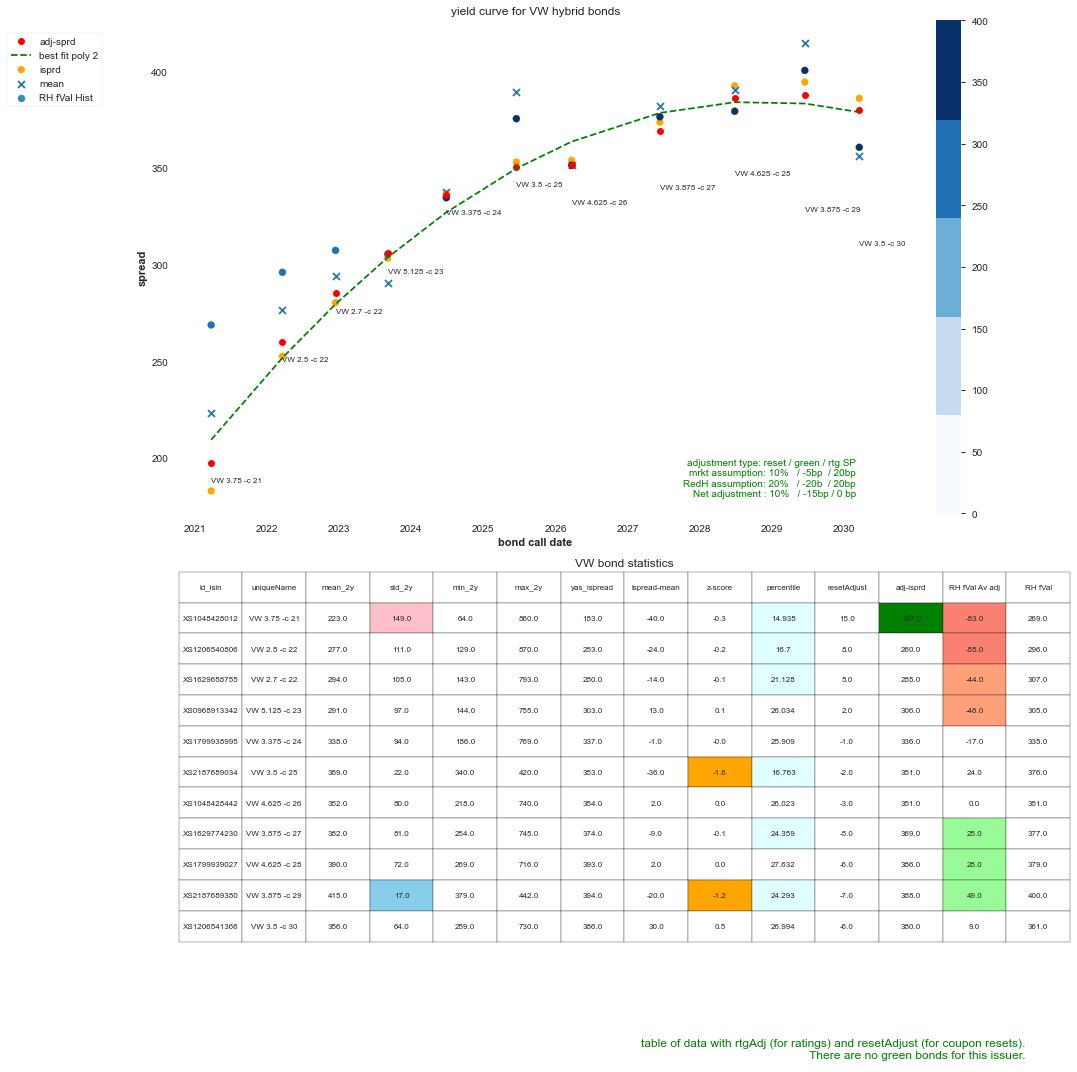

the file is saved here:
C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\pdfData\adjusted yld curve 2020-08-20 14_06_35.pdf


In [323]:
fig, ax = plt.subplots(2,1, figsize=(15,15), tight_layout=True)

cmap = mpl.cm.get_cmap('Blues',5)

ax[0].scatter(x=vw_merged['nxt_call_dt'], y=vw_merged['yas_ispread'], marker='o', label='isprd', ls='-.', color='orange')
ax[0].plot(vw_merged['nxt_call_dt'], vw_merged['adj-isprd'], marker='o', label='adj-sprd',  linestyle='', color='red')
ax[0].scatter(x=vw_merged['nxt_call_dt'], y=vw_merged['mean_2y'], marker='x', label = 'mean')
#ax[0].scatter(x=vw_merged['nxt_call_dt'], y=vw_merged['ewm'], marker='x', label = 'exp mean', color = 'pink')
cax = ax[0].scatter(x=vw_merged['nxt_call_dt'], y=vw_merged['RH fVal'], marker='o', s=50,
              label = 'RH fVal Hist', c=vw_merged['RH fVal'], cmap=cmap, vmin=0, vmax=400, alpha=1)

fig.colorbar(cax, ax=ax[0])


# ax[0].set_label('Color Intensity')

ax[0].xaxis.set_label_text('bond call date', weight='bold')
ax[0].yaxis.set_label_text('spread', weight='bold')
ax[0].title.set_text('yield curve for VW hybrid bonds')

# colours


# plot a table
#pd.plotting.table(ax[1],chartDF,loc='center', colWidths=[0.1]*2 + [0.05]*(len(chartDF.columns)-2)).set_fontsize('large')
#ax[1].table(cellText=chartDF.values, colLabels=chartDF.columns, bbox=[0,0.25,1,0.75],cellLoc='center')#.auto_set_font_size(False)
the_table = ax[1].table(cellText=chartDF.values, colLabels=chartDF.columns, bbox=[0,0.25,1,0.75],
                        cellLoc='center',cellColours=coloursDF.values)
the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
the_table.scale(1, 1)
ax[1].title.set_text('example dataframe with plot')
ax[1].axis('off')


# label the points
for i, txt in enumerate(vw_merged['uniqueName'].values):
    n = 10
    if i == 6:
        n=20    
    if i == 7:
        n=30
    if i == 8:
        n=40
    if i==9:
        n=60
    if i==10:
        n=70
    ax[0].annotate(txt, (vw_merged['nxt_call_dt'][i], vw_merged['adj-isprd'][i]-n), fontsize=8)

# adjustments comment
adjComment =               'adjustment type: reset / green / rtg SP\n'
adjComment =  adjComment + f'mrkt assumption: {mrkt_assumption_resetFactor_pct}%   / {mrkt_assumption_green_bps}bp  / 20bp\n'
adjComment =  adjComment + f'RedH assumption: {RH_assumption_resetFactor_pct}%   / {RH_assumption_green_bps}b  / 20bp\n'
adjComment =  adjComment + f'Net adjustment : {(RH_assumption_resetFactor_pct-mrkt_assumption_resetFactor_pct)}%   / {RH_assumption_green_bps-mrkt_assumption_green_bps}bp / 0 bp\n'
    
# anotate the chart
ax[0].text(0.95, 0.01, adjComment,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0].transAxes,
        color='green', fontsize=10)



# anotate the table
ax[1].text(0.95, 0.01, 'table of data with rtgAdj (for ratings) and resetAdjust (for coupon resets).\n There are no green bonds for this issuer.',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1].transAxes,
        color='green', fontsize=12)


# add RH fair value curve


# line of best fit
# first convert datetime to numbers
#dateIntegers = [int (i.strftime('%Y%m%d')) for i in vw_merged['nxt_call_dt'].values]
dateIntegers = pd.to_datetime(vw_merged['nxt_call_dt']).values.astype(float)


y = vw_merged['adj-isprd'].values.tolist()
bestFit = np.polyfit(dateIntegers, vw_merged['adj-isprd'].values.tolist(), 2)

p = np.poly1d(bestFit)
ax[0].plot(vw_merged['nxt_call_dt'],p(dateIntegers),  linestyle='--', color='green', label='best fit poly 2')

ax[0].legend(loc='center right', bbox_to_anchor=(-0.1, 0.9))
plt.title('VW bond statistics')
plt.show()


# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'adjusted yld curve ' + ts + '.pdf'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'pdfData', fileToSave)


fig.tight_layout()
fig.savefig(fileToSave)
print('the file is saved here:')
print(fileToSave)


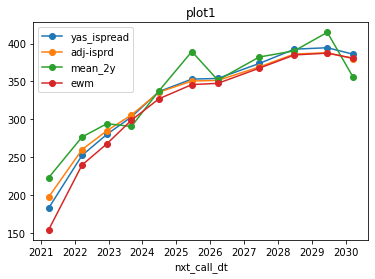

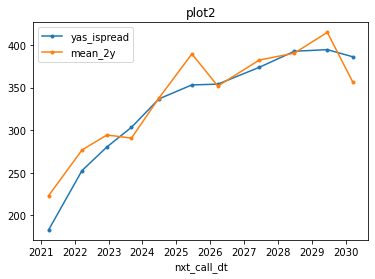

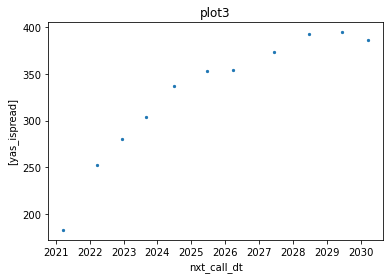

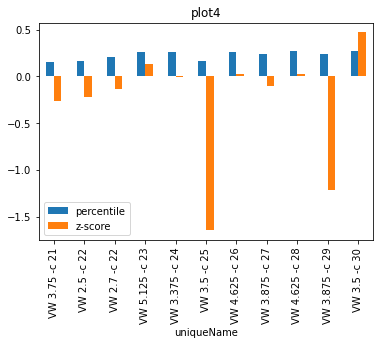

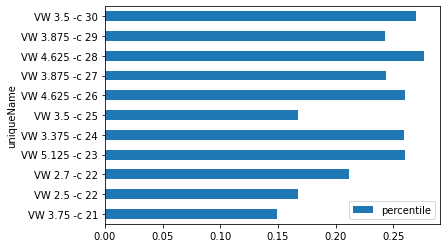

In [31]:
# plot data
vw_merged.plot(x='nxt_call_dt', y=['yas_ispread', 'adj-isprd','mean_2y', 'ewm'], marker='o', title="plot1")
vw_merged.plot(x='nxt_call_dt', y=['yas_ispread','mean_2y'], marker='.', title="plot2")
vw_merged.plot(x='nxt_call_dt', y=['yas_ispread'], kind='scatter', marker='.', title="plot3")
vw_merged.plot(x='uniqueName', y=['percentile', 'z-score'] ,kind='bar', title="plot4")
vw_merged.plot(x='uniqueName', y='percentile' ,kind='barh')


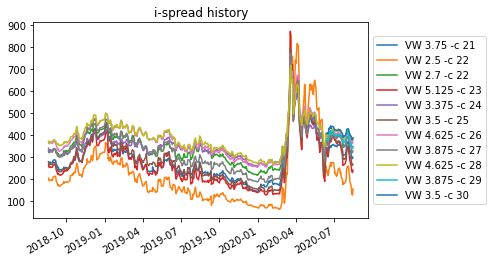

In [32]:
# Plot history with correct labels


ax = vwHist.plot()
# list of bonds
#print(vw_merged[['id_isin','security_name']])

# prepare legend list
legendList = []
for i in all_VW_bonds:
    counter = 0
    for j in vw_merged['id_isin']:
        if j == i:
            #print(i, j, vw_merged['security_name'][counter], counter)
            legendList.append(vw_merged['uniqueName'][counter])  #security_name

        counter = counter + 1

# print(legendList)


# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.legend(legendList, loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('i-spread history')
ax


### box and whisker plot

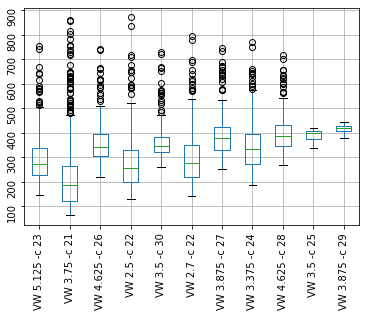

In [55]:
#df = pd.DataFrame(vwHist[('XS1206541366 Corp', 'blp_i_sprd_mid')].values, columns=['this'])
#df['that']=vwHist[('XS1799939027 Corp', 'blp_i_sprd_mid')].values
df = pd.DataFrame(vwHist[vwHist.columns].values, columns=vw['uniqueName'].values)
df



boxplot = df.boxplot(column=vw['uniqueName'].values.tolist()).tick_params(labelrotation=90)

### subplots

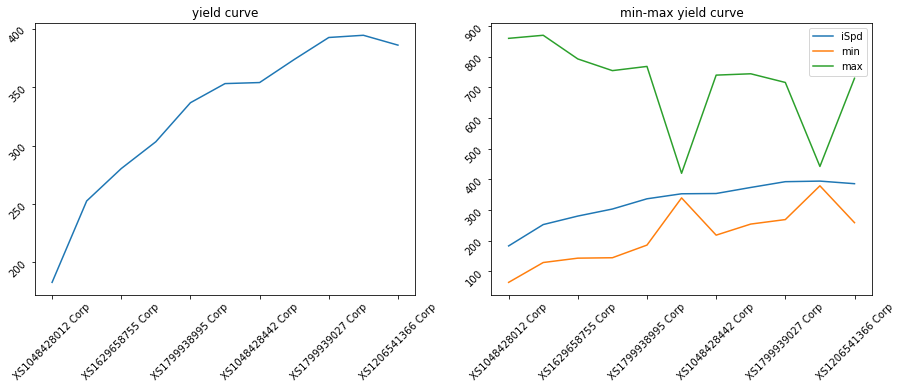

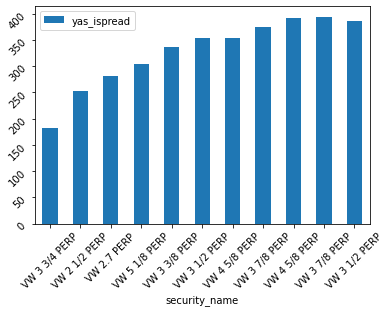

In [34]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5) )

vw_merged['yas_ispread'].plot(ax=axes[0])
vw_merged['yas_ispread'].plot(ax=axes[1])
vw_merged['min_2y'].plot(ax=axes[1])
vw_merged['max_2y'].plot(ax=axes[1])

axes[0].set_title('yield curve')
axes[0].tick_params(labelrotation=45)
axes[1].legend(['iSpd','min','max'])
axes[1].set_title('min-max yield curve')
axes[1].tick_params(labelrotation=45)

vw_merged[['security_name', 'yas_ispread']].plot(x='security_name', y='yas_ispread', kind='bar').tick_params(labelrotation=45)



# Spread to Benchmark History
Define a benchmark bond and get the spread to benchmark history for all other bonds in the list.

In [35]:
def spreadToBenchmarkHistory(isinBench: str, isin_list: list):
    """
    define a benchmark bond and get spread to benchmark hiistory for bonds in hthe list.
    
        input:
            isinBench: the benchmark isin
            isin_list: the benchmark isins list
            
        output:
            df: dataframe containing benchmark histories
            
    """
    
    # remove benchmark from list
    if isinBench in isin_list:
        print('isin removed')
        isin_list.remove(isinBench)
    else:
        print('isin not in bench')
    

    # list of isins
    isin_list_corp = [i + ' Corp' for i in isin_list]
    print('here is the list: ', isin_list)
    

    # fields
    fieldList = 'blp_i_sprd_mid'

    # start and end dates to use
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)



    # request from bbg returning a MultiIndex DataFrame object - for the isin list    
    bondDataHist = blp.bdh(
        tickers= isin_list_corp, flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )

    # request from bbg returning a MultiIndex DataFrame object - for the isin benchmark  
    benchDataHist = blp.bdh(
        tickers= isinBench+ ' Corp', flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )

    # MultiIndex dataframe for spreads
    spreadDataHist = bondDataHist.sub(benchDataHist[(isinBench+ ' Corp', 'blp_i_sprd_mid')], axis=0)
    
    # print(spreadDataHist)
    # rename columns
    spreadDataHist.columns = isin_list
    
    
    return spreadDataHist


benchmarkBond = 'XS1048428442'
vw_spd_to_bmk_hist = spreadToBenchmarkHistory(benchmarkBond, listOfBonds)


#print(type(vw_spd_to_bmk))
#vw_spd_to_bmk.rename(columns={"('XS0968913342 Corp', 'blp_i_sprd_mid')": 'testBond'}, inplace=True)
vw_spd_to_bmk_hist





isin removed
here is the list:  ['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 'XS2187689034', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366']
lets go between today and 2 years ago
today: 2020-08-17
2y ago: 2018-08-18


XS1048428012  XS1206540806  XS1629658755  XS0968913342  \
2018-08-20       -50.554      -125.438       -64.637        10.380   
2018-08-21       -50.119      -127.468       -67.288         8.419   
2018-08-22       -51.019      -127.768       -67.849         9.627   
2018-08-23       -52.318      -129.758       -68.244         8.962   
2018-08-24       -50.031      -131.354       -71.751         6.678   
...                  ...           ...           ...           ...   
2020-08-10       -43.305      -190.388       -99.961        30.418   
2020-08-11       -44.609      -209.983      -105.744        33.801   
2020-08-12       -46.645      -208.809      -107.173        32.668   
2020-08-13       -48.240      -213.372      -111.240        33.673   
2020-08-14       -48.568      -191.940      -107.426        33.105   

            XS1799938995  XS2187689034  XS1629774230  XS1799939027  \
2018-08-20       -54.530        38.623        -2.557        41.681   
2018-08-21       -54.428        38.924        -1.238        41.499   
2018-08-22       -55.112        39.974        -0.827        43.545   
2018-08-23       -54.987        39.937        -0.061        45.825   
2018-08-24       -56.869        39.026        -2.091        43.063   
...                  ...           ...           ...           ...   
2020-08-10       -69.714        17.831       -14.119        33.730   
2020-08-11       -76.193        21.243       -19.380        36.267   
2020-08-12       -77.224        21.084       -20.828        35.993   
2020-08-13       -78.593        19.678       -20.958        37.338   
2020-08-14       -79.652        20.000       -20.326        37.471   

            XS2187689380  XS1206541366  
2018-08-20           NaN           NaN  
2018-08-21           NaN           NaN  
2018-08-22           NaN           NaN  
2018-08-23           NaN           NaN  
2018-08-24           NaN           NaN  
...                  ...           ...  
2020-08-10        -2.192        33.962  
2020-08-11        -0.964        36.740  
2020-08-12        -2.566        36.717  
2020-08-13        -2.147        38.164  
2020-08-14        -1.572        39.894  

[508 rows x 10 columns]

## A summary of all the time series data

In [36]:
vw_spd_to_bmk_hist.describe()

XS1048428012  XS1206540806  XS1629658755  XS0968913342  XS1799938995  \
count    508.000000    508.000000    508.000000    508.000000    508.000000   
mean     -61.062376   -128.683024    -74.942319      4.354848    -57.380478   
std       23.029086     82.145470     35.921191     25.597104     29.672155   
min     -101.353000   -225.360000   -144.986000    -45.356000   -113.143000   
25%      -75.497500   -168.786250    -97.407250    -20.028750    -77.812250   
50%      -68.819000   -151.458500    -82.255000      3.681000    -62.007000   
75%      -47.556750   -129.666500    -57.490500     30.211000    -41.429250   
max       14.676000    192.901000    130.031000     50.411000     52.810000   

       XS2187689034  XS1629774230  XS1799939027  XS2187689380  XS1206541366  
count    508.000000    508.000000    508.000000     46.000000      46.00000  
mean      30.462311    -14.081919     38.621098      7.081587      32.38287  
std       14.656919     20.615698     15.078025      7.526411       6.10052  
min       -3.703000    -55.157000    -40.961000     -2.566000      23.60100  
25%       20.260750    -32.083750     30.818250      1.741250      26.71050  
50%       26.539000    -10.333500     40.033000      4.974500      31.24250  
75%       40.343250      2.600000     47.429500     11.214750      36.81875  
max       69.802000     29.022000     70.439000     25.777000      43.25700

In [37]:
# save to csv

# time stamp & path etc.
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_isprd_toBMK_HistoryStats ' + ts + '.csv'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'csvData', fileToSave)

# export to csv
vw_spd_to_bmk_hist.describe().to_csv(fileToSave)
print('CSV file saved here: ', fileToSave)


# time stamp & path etc.
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_isprd_toBMK_HistoryStats ' + ts + '.xlsx'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'xlsxData', fileToSave)

# export to xlsx
vw_spd_to_bmk_hist.describe().to_excel(fileToSave)
print('XLSX file saved here: ', fileToSave)




CSV file saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\csvData\bond_isprd_toBMK_HistoryStats 2020-08-17 11_20_04.csv
XLSX file saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\xlsxData\bond_isprd_toBMK_HistoryStats 2020-08-17 11_20_04.xlsx


<class 'matplotlib.axes._subplots.AxesSubplot'>


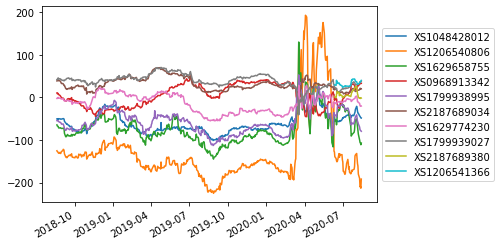

In [38]:
# plot this

ax = vw_spd_to_bmk_hist.plot()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.tight_layout()
ax

print(type(ax))

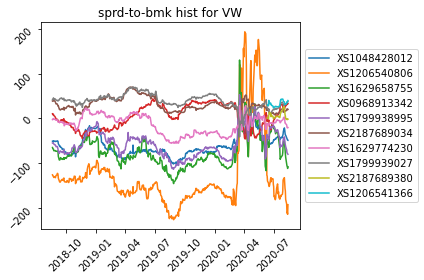

In [39]:
# method 2 for plotting
fig, ax = plt.subplots()
ax.plot(vw_spd_to_bmk_hist)
ax.title.set_text('sprd-to-bmk hist for VW')
ax.legend(vw_spd_to_bmk_hist.columns, loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.tick_params(labelrotation=45)
fig.tight_layout()

# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'spreadImage ' + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)



In [40]:
# give columns nice names

vw_spread_list = [] # list to store names
for i in vw_spd_to_bmk.columns:
    vw_spread_list.append(vw_merged.loc[vw_merged['id_isin'] == i, 'uniqueName'].item())
    
print(vw_spread_list)
# print(type(vw_spread_list))    
    

NameError: name 'vw_spd_to_bmk' is not defined

### examples of histograms

##### one specific bond

In [ ]:
#print(type(vw_spd_to_bmk[('XS0968913342 Corp','blp_i_sprd_mid')]))
bond_to_plot = 'XS0968913342'
bond_name = vw_merged.loc[vw_merged['id_isin'] == bond_to_plot, 'uniqueName'].item()
#vw_spd_to_bmk_hist[(bond_to_plot)].hist(bins=20, color='yellow',edgecolor='k')
fig, ax = plt.subplots()
plt.hist(vw_spd_to_bmk_hist[(bond_to_plot)],bins=20, color='yellow',edgecolor='k')
plt.axvline(vw_spd_to_bmk_hist[(bond_to_plot)].mean(), color='green', linestyle='dashed', linewidth=2, label='mean')
plt.axvline(vw_spd_to_bmk_hist[(bond_to_plot)].mean()+vw_spd_to_bmk_hist[('XS0968913342')].std(), color='green', linestyle='dashed', linewidth=1, label='mean+std')
plt.axvline(vw_spd_to_bmk_hist[(bond_to_plot)].mean()-vw_spd_to_bmk_hist[('XS0968913342')].std(), color='green', linestyle='dashed', linewidth=1, label='mean-std')
plt.axvline(vw_spd_to_bmk_hist[(bond_to_plot)].values[-1], color='red', linestyle='dashed', linewidth=3, label='current')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)
plt.title(f'histogram for {bond_name} vs benchmark')
plt.tight_layout()
plt.show()

print('the isin number is: ', bond_to_plot)
print('the mean spread is: ',round(vw_spd_to_bmk_hist[('XS0968913342')].mean(),1))
print('the stdev spread is: ',round(vw_spd_to_bmk_hist[('XS0968913342')].std(),1))
print('the current spread is: ', round(vw_spd_to_bmk_hist[('XS0968913342')].values[-1],1))
print('--------------------')


# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = bond_to_plot + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)
print('the file is saved here: ', fileToSave)


##### all the bonds (multi plot)

In [ ]:
vw_spd_to_bmk.hist(bins=20, color='orange',edgecolor='k')  #.subplots_adjust(hspace=0)
plt.show()

In [ ]:

fig, ax = plt.subplots(tight_layout=True)

ax.hist(vw_spd_to_bmk)
#ax.legend(vw_spd_to_bmk.columns)
ax.legend(vw_spread_list, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=8)
ax.title.set_text('sprd-to-bmk histogram for VW bonds')

ax.axvline(vw_spd_to_bmk.mean().mean(), color='blue', linestyle='dashed', linewidth=3, label='mean')
ax.axvline(vw_spd_to_bmk.mean().mean()+vw_spd_to_bmk.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+std')
ax.axvline(vw_spd_to_bmk.mean().mean()-vw_spd_to_bmk.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+std')
ax.axvline(vw_spd_to_bmk.mean().mean()+2*vw_spd_to_bmk.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+2*std')
ax.axvline(vw_spd_to_bmk.mean().mean()-2*vw_spd_to_bmk.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+2*std')

#fig.tight_layout()
#vw_spd_to_bmk.mean()

plt.show()

print('the mean is: ', round(vw_spd_to_bmk.mean().mean(),1))
print('the st dev is: ', round(vw_spd_to_bmk.std().mean(),1))



### some statistics

In [ ]:

# print('the mean is: \n', vw_spd_to_bmk.mean())
# print('the standard deviation is: \n', vw_spd_to_bmk.std())



vw_spd_to_bmk.mean().plot(kind='barh', label='mean', color='orange', 
                          xerr=vw_spd_to_bmk.std(), 
                          title='mean spread with var').legend(['mean'])
# add dots for current spread
#vw_spd_to_bmk.mean().plot(kind='barh', label='current', color='red').legend(['current'])

plt.yticks(range(len(vw_spread_list)),vw_spread_list)

plt.tight_layout()
plt.show()


# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'meanSpreads_and_Variances ' + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)



### some z scores

In [ ]:
# zscore is: (value - mean() / std())
vw_spd_to_bmk_df = pd.DataFrame({'bonds':vw_spread_list,'mean_spd_to_bmk':vw_spd_to_bmk.mean(), 'st dev spd_to_bmk':vw_spd_to_bmk.std()})
vw_spd_to_bmk_df['id_isin'] = vw_spd_to_bmk_df.index
#vw_spd_to_bmk_df.merge(vw_merged,how='left', right_on='id_isin')

#x = vw_merged['id_isin'].loc[benchmarkBond]
#print(x)
# x = vw.loc[benchmarkBond+" Corp", 'yas_ispread']
# print(x)

#vw_spd_to_bmk_df['sprd_to_bmk'] = vw_spd_to_bmk_df['yas_ispread']  - vw.loc[benchmarkBond+" Corp", 'yas_ispread']

vw_spd_to_bmk_df = pd.merge(vw_spd_to_bmk_df, vw_merged, on='id_isin')
vw_spd_to_bmk_df['sprd_to_bmk'] = vw_spd_to_bmk_df['yas_ispread']  - vw.loc[benchmarkBond+" Corp", 'yas_ispread']

vw_spd_to_bmk_df['z-score spd_to_bmk'] = (vw_spd_to_bmk_df['sprd_to_bmk']-vw_spd_to_bmk_df['mean_spd_to_bmk'])/vw_spd_to_bmk_df['st dev spd_to_bmk']
vw_spd_to_bmk_df
#vw_merged




In [ ]:
# plot some of the new data

fig, axs = plt.subplots()
axs.barh(vw_spd_to_bmk_df['bonds'],vw_spd_to_bmk_df['z-score spd_to_bmk'],  
                         label='z-score to bmk', fc=(1, 0, 0, 0.5),ls='dashed', lw=3)
axs.barh(vw_spd_to_bmk_df['bonds'],vw_spd_to_bmk_df['z-score'],  
                         label='z-score for bond', fc=(0, 0, 1, 0.5))
plt.legend()
plt.tight_layout()
plt.title('z-scores')
plt.show()





# to do comments

    1. curve at a point in history, say 60 days ago, 120 days ago.
    2. plot current point on mean, variance bar chart.
    3. use cmap and colour bar for additional dimension (also use size).
    4. curve fitting - best fit or smooth curve / polynomial between lines.






# Blank line

# Blank line


## Get historic data from file

In [ ]:


def getIsinHistoryFrom_File():
    '''
    function to get ISIN history from a file
    '''


    # import XLSX data file
    dir_path = os.path.abspath('')

    # get items from sheet (in a sub folder)
    fileToGet = 'hybrid_BBG_raw.xlsx'


    # join file and correct folder
    fileToGet = os.path.join(dir_path, 'dataFolder', 'xlsxData', fileToGet)
    print(fileToGet)
    print('getting the file')

    xl = pd.ExcelFile(fileToGet)

    print('got the file')


    # the names of the available sheets
    print('getting security list from:', xl.sheet_names)

    # print(type(xl))
    for name in xl.sheet_names:
        bhDF = xl.parse(name)
    
    # print(bhDF)
    return bhDF



r = getIsinHistoryFrom_File()
r




# Now get the bond data


In [ ]:
# put all isin's in a list
isin = df.iloc[:,1].tolist()
securtiyList = [x + " Corp" for x in isin]

# make the lists unique (and keep the order)
securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

# get the data from bloomberg
print('getting data from bbg')
bondData = getListDataFromBbg(securtiyList, fieldList)
print('the data is collected')

%time

In [ ]:
# We can inspect the shape ofthe data here
bondData.shape

In [ ]:
bondData

In [ ]:
if bondData.shape[0] / len(isin):
    # remove duplicaes
    print('more rows than isins')
    bondData.drop_duplicates()

bondData.shape[0]



# Time to save the Data to file



In [ ]:
def store_data(someData):
    ''' function to store data to file 
    
    if data is stored:
        return: True otherwise False
    '''

    dataWritten = False

    # location to store file
    pathToStore = os.path.abspath('')
    # use a subfolder callled data folder
    pathToStore = os.path.join(pathToStore, 'dataFolder')
    print(f'the file resides here: {pathToStore}')

    # file name
    fileDateTime = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
    

    fileToStoreXLSX = 'hybrids_results ' + fileDateTime + '.xlsx'
    fileToStoreHTML = 'hybrids_results ' + fileDateTime + '.html'
    print(f'the name of the excel file: {fileToStoreXLSX}')
    print(f'the name of the HTML file: {fileToStoreHTML}')

    # full path name
    fullPathToStoreXLSX = os.path.join(pathToStore, fileToStoreXLSX)
    fullPathToStoreHTML = os.path.join(pathToStore, fileToStoreHTML)    
    
    # save the file (to excel and html)
    df = pd.DataFrame(someData)
    df.to_excel(fullPathToStoreXLSX)
    df.to_html(fullPathToStoreHTML)
    dataWritten = True


    return dataWritten

In [ ]:
# run the function to store data

storeIt = store_data(bondData)
if storeIt == True:
    print('the data is stored')
    
    

# Lets draw some example charts now

In [ ]:
# plot maturity vs spread as a simple example directly from pandas
#bondData.plot(x='nxt_call_dt', y='z_sprd_mid',kind='scatter')
bondData.plot(x='nxt_call_dt',y='z_sprd_mid')



### a vertical bar chart

In [ ]:
# plot a bar chart of the same data
# bondData.plot.bar(x='nxt_call_dt',y='z_sprd_mid')
t1 = time.time()


chart = bondData.plot(x='nxt_call_dt',y='z_sprd_mid', kind='barh')
chart.set_xlim(0,5000)

# change the y label
chart.set_ylabel('a list of Hybrid bonds')

# remove the y tick labels
chart.set_yticklabels([])




t2 = time.time()
print('time taken: ',round(t2-t1,2))





In [ ]:
#bondData.hist(x='nxt_call_dt',y='z_sprd_mid')



### a histogram of the z spreads in the hybrid space

In [ ]:
# convert to numeric
z_sprd_mid = pd.to_numeric(bondData['z_sprd_mid'])
yas_ispread = pd.to_numeric(bondData['yas_ispread'])


df = pd.DataFrame({
    'yas_ispread': yas_ispread,
    'z_sprd_mid':z_sprd_mid
    })

#hist = df['yas_ispread'].hist(bins=50)
#hist1 = df['z_sprd_mid'].hist(bins=50)


hist3 = bondData['z_sprd_mid'].hist(bins=50)




# Here are some statistics


In [ ]:
# the average spread
x= bondData['z_sprd_mid'].mean()
x = round(x, 2)
print('the average z spread is:', x)


y= bondData['z_sprd_mid'].std()
y = round(y)
print('the standard deviation is:', y)

x, y = bondData['z_sprd_mid'].min() , bondData['z_sprd_mid'].max()
x, y = round(x), round(y)
print('min, max = ', x,",", y)

s = bondData['z_sprd_mid'].sem()
s = round(s,2)
print('standard error', s)



# lets get a regression

use the linear regression model in sklearn to get the linear regression.
example is here:


In [ ]:
# linear regression

reg = linear_model.LinearRegression()

dependentVariables = bondData['nxt_call_dt'].values.reshape((-1,1))
independentVariables = bondData['z_sprd_mid'].values

# reg.fit(reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2]))

# model = reg.fit(dependentVariables,independentVariables)
# print(model)



# bonds crossing one year
This will be moved to a new module specifically for corporate hybrids.


In [ ]:
# this will be moved to the hybrids module.



In [ ]:
# oneYearBonds(bondData)

In [ ]:
# delete the module so that it can be restarted for testing.
if 'hybridsMethods' in sys.modules:
    print('hybridsMethods was loaded')
    del sys.modules["hybridsMethods"]
    print('the module is now removed')


In [ ]:
# import the hybrids module for testing
import hybridsMethods as hm

In [ ]:

hm.oneYearBonds(100)



# Other not used code...


In [ ]:
def examples():
    """
    examples of how to get basic data from bbg
    """

    # get some data for a single name
    x = blp.bdp('BDEV LN Equity', 'px_last')
    print(x)
    print('the type of x', type(x))
    print('the value of x:', x.iloc[0]['px_last'])


    # get multiple data for a single name
    y = blp.bdp('BDEV LN Equity', flds=['px_bid', 'px_ask'])
    print(y)


    # get multiple data for multiple names
    z = blp.bdp(tickers=['BDEV LN Equity', 'BARC LN Equity'], flds=['px_bid', 'px_ask'])
    print(z)
    print('here is the bdev ask >>>', z.loc['BDEV LN Equity','px_ask'])

    # get multiple data for multiple names
    z = blp.bdp(tickers=['XS2011260705 Corp'], flds=['z_sprd_mid', 'z_sprd_mid'])
    print(z)
    print('here is the bdev ask >>>', z.loc['XS2011260705 Corp','z_sprd_mid'])

examples()


In [ ]:
def get_bonds():
    """
    function to get bond data from bloomberg using tickers in an excel sheet.

    return:
        data - a pandas data set
    """

    print('getting bond data...')
    # securtiyList = ['US29265WAA62 Corp', 'XS1713463559 Corp', 'XS2000719992 Corp', 'XS0954675129 Corp', 'XS0954675129 Corp']
    fieldList = ['ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
                'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
                'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody','rtg_sp']

    # the script fis here
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.path.abspath('')


    # get items from sheet (in the same folder)
    fileToGet = 'hybridSecurityList.xlsx'
    # join file and correct folder
    fileToGet = os.path.join(dir_path, fileToGet)
    secListXlsx = pd.ExcelFile(fileToGet)
    
    # the names of the available sheets
    print('getting security list from:', secListXlsx.sheet_names)
    df = pd.DataFrame(secListXlsx.parse('tickers'))
    print('summary of the data')
    print(df.info)
    
    # put all isin's in a list
    isin = df.iloc[:,1].tolist()
    securtiyList = [x + " Corp" for x in isin]

    # make the lists unique (and keep the order)
    securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

    # get the data from bloomberg
    print('getting data from bbg')
    bondData = getListDataFromBbg(securtiyList, fieldList)

    #print('number of columns:', data.head())
    print('data is fetched:')
    print(bondData.info)

    return bondData

In [ ]:
def main():

    # measure time for some basic examples
    t1 = time.time()
    
    # basic example (not used now)
    #examples()
    
    bondData = get_bonds()    
    t2 = time.time()

    # save data to file
    isStored = store_data(bondData)

    t3 = time.time()


    print('the time take is:', round(t2-t1, 3) , 'seconds')


In [ ]:
# this works the same in a jupyter notebook which runs commands in sequence.
# there is no hoisting unless the code is added to a main() function.


if __name__ == "__main__":
    #main()
    pass




In [ ]:
os.system('jupyter nbconvert --to html hybridsAnalysis 03.ipynb')
